# Model Development with 3 Labels

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV , cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, f1_score, average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the cleaned CTG dataset from a CSV file into a pandas DataFrame
CTG = pd.read_csv("data/after_EDA_CTG_dataset.csv")

# Set the pandas option to display all columns when printing the DataFrame
# This ensures that no columns are hidden, which is useful when dealing with wide DataFrames
pd.set_option('display.max_columns', None)

# Display a summary of the DataFrame, including the number of non-null entries, data types of each column, and memory usage
CTG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FHR_Baseline          2115 non-null   float64
 1   Accelerations         2115 non-null   float64
 2   Fetal_Movements       2115 non-null   float64
 3   Uterine_Contractions  2115 non-null   float64
 4   Light_Decels          2115 non-null   float64
 5   Severe_Decels         2115 non-null   float64
 6   Prolonged_Decels      2115 non-null   float64
 7   Abnormal_STV_Percent  2115 non-null   float64
 8   STV_Mean              2115 non-null   float64
 9   Abnormal_LTV_Percent  2115 non-null   float64
 10  LTV_Mean              2115 non-null   float64
 11  Hist_Width            2115 non-null   float64
 12  Hist_Min              2115 non-null   float64
 13  Hist_Mode             2115 non-null   float64
 14  Hist_Mean             2115 non-null   float64
 15  Hist_Median          

In [4]:
# List of columns that should be converted to integer type
ints = ["FHR_Baseline", "FHR_Class", "Fetal_State"]

# Loop through each column and convert the data type of the columns
for column in ints:
    CTG[column] = CTG[column].astype("int64")
CTG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FHR_Baseline          2115 non-null   int64  
 1   Accelerations         2115 non-null   float64
 2   Fetal_Movements       2115 non-null   float64
 3   Uterine_Contractions  2115 non-null   float64
 4   Light_Decels          2115 non-null   float64
 5   Severe_Decels         2115 non-null   float64
 6   Prolonged_Decels      2115 non-null   float64
 7   Abnormal_STV_Percent  2115 non-null   float64
 8   STV_Mean              2115 non-null   float64
 9   Abnormal_LTV_Percent  2115 non-null   float64
 10  LTV_Mean              2115 non-null   float64
 11  Hist_Width            2115 non-null   float64
 12  Hist_Min              2115 non-null   float64
 13  Hist_Mode             2115 non-null   float64
 14  Hist_Mean             2115 non-null   float64
 15  Hist_Median          

In [5]:
# Drop the 'FHR_Class' and 'Fetal_State' columns from the dataset to create the feature set 'X'
# 'X' will contain all the features except the target labels
X = CTG.drop(columns=["FHR_Class", "Fetal_State"])
# Assign the 'Fetal_State' column from the dataset to the target variable 'y' 
# 'y' is the label we want to predict using the features in 'X'
y = CTG["Fetal_State"]

# Display the descriptive statistics of the features in 'X'
X.describe().T  

,count,mean,std,min,25%,50%,75%,max
FHR_Baseline,2115.0,1.333017e+02,9.836399,106.000000,126.000000,133.000000,140.000000,160.000000
Accelerations,2115.0,3.186288e-03,0.003870,0.000000,0.000000,0.002000,0.006000,0.019000
Fetal_Movements,2115.0,9.508274e-03,0.046783,0.000000,0.000000,0.000000,0.003000,0.481000
Uterine_Contractions,2115.0,4.384870e-03,0.002941,0.000000,0.002000,0.005000,0.007000,0.015000
Light_Decels,2115.0,1.899291e-03,0.002965,0.000000,0.000000,0.000000,0.003000,0.015000
Severe_Decels,2115.0,3.309693e-06,0.000057,0.000000,0.000000,0.000000,0.000000,0.001000
Prolonged_Decels,2115.0,1.593381e-04,0.000591,0.000000,0.000000,0.000000,0.000000,0.005000
Abnormal_STV_Percent,2115.0,4.697778e+01,17.180933,12.000000,32.000000,49.000000,61.000000,87.000000
STV_Mean,2115.0,1.335035e+00,0.884111,0.200000,0.700000,1.200000,1.700000,7.000000
Abnormal_LTV_Percent,2115.0,9.789598e+00,18.329675,0.000000,0.000000,0.000000,11.000000,91.000000


In [6]:
# Set a random seed for reproducibility
SEED = 83

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Scale the features using StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Initial Model Training and Evaluation

In [8]:
# Logistic Regression
lr = LogisticRegression(random_state=SEED, solver='liblinear', max_iter=1000)
lr.fit(scaled_X_train, y_train)
lr_predictions = lr.predict(scaled_X_test)
lr_report = classification_report(y_test, lr_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("Classification Report:\n", lr_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.93      0.97      0.95       337
     Suspect       0.64      0.59      0.61        51
Pathological       0.93      0.71      0.81        35

    accuracy                           0.90       423
   macro avg       0.83      0.76      0.79       423
weighted avg       0.90      0.90      0.90       423



In [9]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=SEED)
rf.fit(scaled_X_train, y_train)
rf_predictions = rf.predict(scaled_X_test)
rf_report = classification_report(y_test, rf_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("Classification Report:\n", rf_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      0.98      0.97       337
     Suspect       0.79      0.67      0.72        51
Pathological       0.97      0.89      0.93        35

    accuracy                           0.94       423
   macro avg       0.90      0.84      0.87       423
weighted avg       0.93      0.94      0.93       423



In [10]:
# KNeighbors Classifier
knn = KNeighborsClassifier()
knn.fit(scaled_X_train, y_train)
knn_predictions = knn.predict(scaled_X_test)
knn_report = classification_report(y_test, knn_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("Classification Report:\n", knn_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.96      0.94       337
     Suspect       0.57      0.51      0.54        51
Pathological       0.93      0.71      0.81        35

    accuracy                           0.88       423
   macro avg       0.80      0.73      0.76       423
weighted avg       0.88      0.88      0.88       423



In [11]:
# Support Vector Classifier (SVC)
svc = SVC(random_state=SEED)
svc.fit(scaled_X_train, y_train)
svc_predictions = svc.predict(scaled_X_test)
svc_report = classification_report(y_test, svc_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("SVC Classification Report:\n", svc_report)

SVC Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       337
     Suspect       0.66      0.61      0.63        51
Pathological       0.96      0.74      0.84        35

    accuracy                           0.91       423
   macro avg       0.85      0.77      0.81       423
weighted avg       0.91      0.91      0.91       423



In [12]:
# Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=SEED)
gb.fit(scaled_X_train, y_train)
gb_predictions = gb.predict(scaled_X_test)
gb_report = classification_report(y_test, gb_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("Classification Report:\n", gb_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      0.97      0.96       337
     Suspect       0.79      0.67      0.72        51
Pathological       0.97      0.91      0.94        35

    accuracy                           0.93       423
   macro avg       0.90      0.85      0.87       423
weighted avg       0.93      0.93      0.93       423



In [13]:
# AdaBoost Classifier
ada = AdaBoostClassifier(random_state=SEED)
ada.fit(scaled_X_train, y_train)
ada_predictions = ada.predict(scaled_X_test)
ada_report = classification_report(y_test, ada_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("Classification Report:\n", ada_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.93      0.92       337
     Suspect       0.54      0.57      0.55        51
Pathological       0.93      0.77      0.84        35

    accuracy                           0.87       423
   macro avg       0.80      0.76      0.77       423
weighted avg       0.87      0.87      0.87       423



By looking at these results, I decided to use RandomForest and AdaBoost models and go on with feature engineering. 

## Random Forest Classifier Hyperparameter Tuning

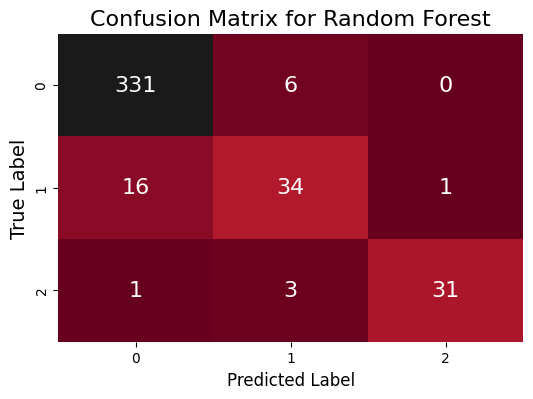

In [74]:
# Creating the confusion matrix
cm_rf = confusion_matrix(y_test, rf_predictions, labels=rf.classes_)

# Visualizing the confusion matrix with a Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="RdGy", cbar=False, annot_kws={"color": "white","fontsize":16})

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix for Random Forest", fontsize=16)
plt.show()

In [76]:
# Get the feature names from the columns of X_train
rf_feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": rf.feature_importances_})

# Round the importance values and display them in sorted order
rf_feature_importance["Importance"] = rf_feature_importance["Importance"].round(3)
rf_feature_importance = rf_feature_importance.sort_values(by="Importance", ascending=False).reset_index(drop=True)

rf_feature_importance

,Feature,Importance
0,Abnormal_STV_Percent,0.127
1,Abnormal_LTV_Percent,0.125
2,STV_Mean,0.121
3,Hist_Mean,0.078
4,Hist_Avg,0.067
5,Hist_Product,0.064
6,Accelerations,0.050
7,Hist_Width,0.040
8,FHR_Baseline,0.040
9,Hist_Mode,0.039


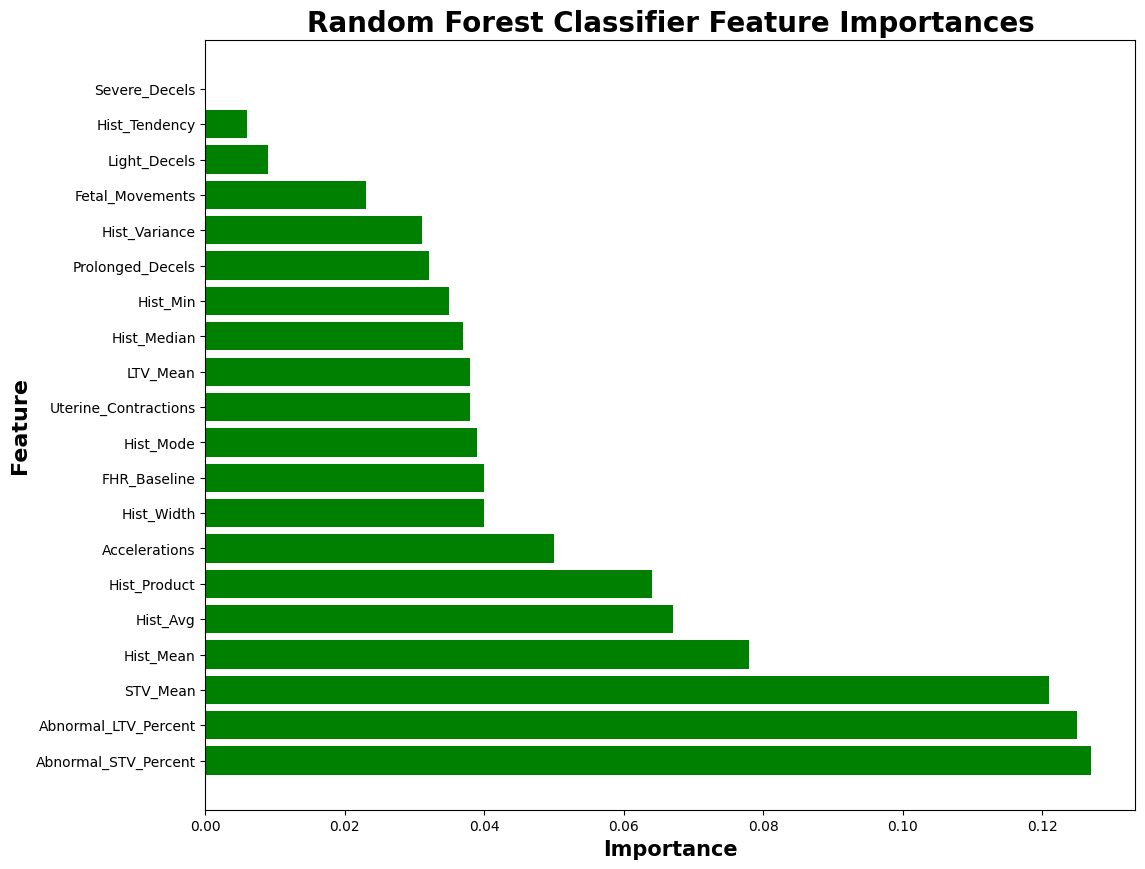

In [18]:
# Create a horizontal bar chart using the feature importance data
plt.figure(figsize=(12, 10))
plt.barh(rf_feature_importance['Feature'], 
         rf_feature_importance['Importance'],
         color='green') 
plt.title("Random Forest Classifier Feature Importances", weight='bold', fontsize=20)
plt.xlabel('Importance', weight='bold', fontsize=15)
plt.ylabel('Feature', weight='bold', fontsize=16)

plt.show()

In [19]:
# Show the variables that did not contributed to the model development
rf_feature_importance[rf_feature_importance['Importance'] < 0.01].reset_index(drop = True)

,Feature,Importance
0,Light_Decels,0.009
1,Hist_Tendency,0.006
2,Severe_Decels,0.000


First I tried to come up with some optimized hyperparameter values with RandomizedSearchCV, because it takes less computing power.

In [21]:
# Stratified K-Fold Cross-Validation
skf_rf = StratifiedKFold(n_splits=6, shuffle=True, random_state=SEED)

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter range for Random Forest
param_distributions_rf = {
    'n_estimators': [118, 119, 120, 150, 200],
    'max_depth': [None, 2, 4, 6, 8],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 3, 4, 5],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.005],
    'criterion': ['entropy', 'gini']
}

# Initialize RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_distributions_rf, 
    n_iter=100,  # Number of parameter settings that are sampled
    cv=skf_rf, 
    n_jobs=-1, 
    verbose=2,
    random_state=SEED
)

# Fit the model
random_search_rf.fit(scaled_X_train, y_train)

# Print the best parameters and the best score
print("Best Hyperparameters for Random Forest:", random_search_rf.best_params_)
print("Best Score for Random Forest:", random_search_rf.best_score_)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
Best Hyperparameters for Random Forest: {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'ccp_alpha': 0.001}
Best Score for Random Forest: 0.9456264775413712


Then I created a more specified list of hyperparameters and used it with GridSearchCV to achieve a better score. 

In [24]:
# Applying cross-validation
cv_scores_rf = cross_val_score(rf,scaled_X_train, y_train, cv=skf_rf, n_jobs=-1)
print(f'Cross-Validation Scores: {cv_scores_rf}')
print(f'Mean CV Score: {cv_scores_rf.mean()}')

# Defining the hyperparameter range
param_grid_rf = {
    'n_estimators': [118,119,120],
    'max_depth': [None,2],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2],
    'max_features': ['sqrt'],
    'ccp_alpha' : [0.001],
    'criterion' : ['entropy','gini']
}

Cross-Validation Scores: [0.92198582 0.93617021 0.93617021 0.91134752 0.97163121 0.95390071]
Mean CV Score: 0.9385342789598109


In [42]:
# Finding the best model with GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=skf_rf, n_jobs=-1, verbose=2)
grid_search_rf.fit(scaled_X_train, y_train)

# Printing the best parameters and model
print("Best Hyperparameters for Random Forest (GridSearchCV):", grid_search_rf.best_params_)
print("Best Score for Random Forest (GridSearchCV):", grid_search_rf.best_score_)

# Use the best estimator from GridSearchCV to predict on the test set
best_rf_model = grid_search_rf.best_estimator_
rf_best_predictions = best_rf_model.predict(scaled_X_test)

# Print the final classification report for the optimized model
rf_best_report = classification_report(y_test, rf_best_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("Final Classification Report for Optimized Random Forest:\n", gb_best_report)

Fitting 6 folds for each of 72 candidates, totalling 432 fits
Best Hyperparameters for Random Forest (GridSearchCV): {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 118}
Best Score for Random Forest (GridSearchCV): 0.9456264775413712
Final Classification Report for Optimized Random Forest:
               precision    recall  f1-score   support

      Normal       0.95      0.98      0.97       337
     Suspect       0.81      0.69      0.74        51
Pathological       0.94      0.91      0.93        35

    accuracy                           0.94       423
   macro avg       0.90      0.86      0.88       423
weighted avg       0.94      0.94      0.94       423



## Gradient Boosting Classifier Feature Engineering

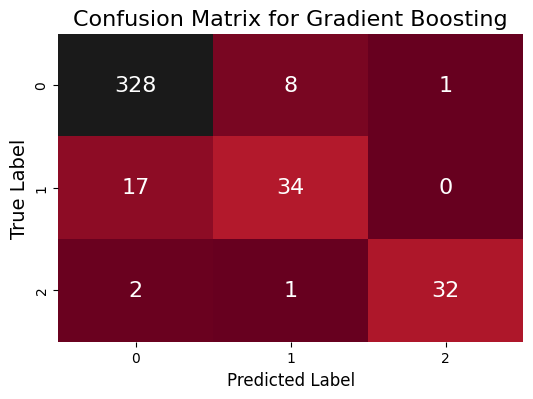

In [50]:
# Creating the confusion matrix
cm_gb = confusion_matrix(y_test, gb_predictions, labels=gb.classes_)

# Visualizing the confusion matrix with a Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="RdGy", cbar=False, annot_kws={"color": "white","fontsize":16})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix for Gradient Boosting", fontsize=16)
plt.show()


In [28]:
# Özellik adlarını almak için X_train'in sütun isimlerini kullanın
gb_feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": gb.feature_importances_})

# Round the importance values and display them in sorted order
gb_feature_importance["Importance"] = gb_feature_importance["Importance"].round(3)
gb_feature_importance = gb_feature_importance.sort_values(by="Importance", ascending=False).reset_index(drop=True)

gb_feature_importance

,Feature,Importance
0,Abnormal_LTV_Percent,0.195
1,Abnormal_STV_Percent,0.193
2,STV_Mean,0.144
3,Hist_Mean,0.140
4,Prolonged_Decels,0.062
5,FHR_Baseline,0.050
6,Accelerations,0.041
7,Hist_Product,0.035
8,Uterine_Contractions,0.034
9,Hist_Mode,0.025


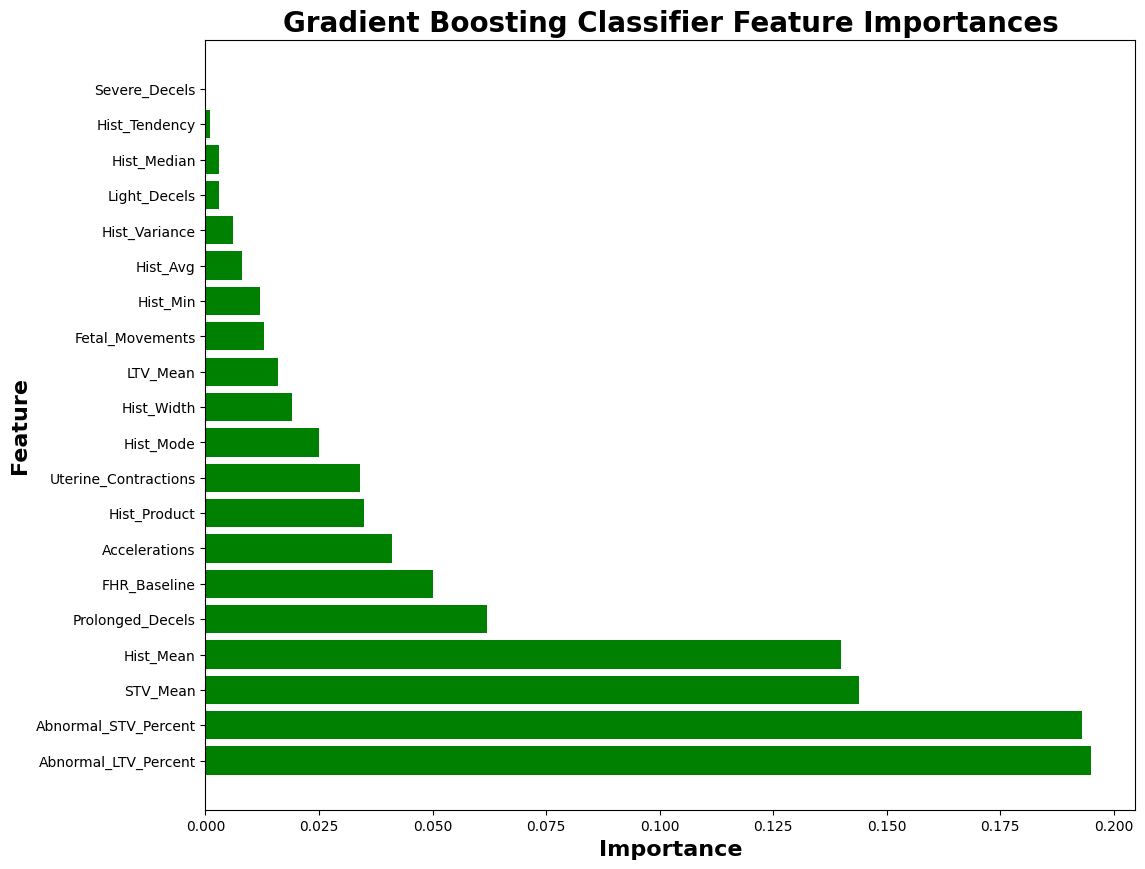

In [29]:
# Create a horizontal bar chart using the feature importance data
plt.figure(figsize = (12,10))
plt.barh(gb_feature_importance['Feature'], 
         gb_feature_importance['Importance'],
         color = 'green')
plt.title("Gradient Boosting Classifier Feature Importances", weight = 'bold',fontsize = 20)
plt.xlabel('Importance', weight = 'bold', fontsize = 16)
plt.ylabel('Feature', weight = 'bold', fontsize = 16)

plt.show()

In [30]:
# Show the variables that did not contribute to the model development
gb_feature_importance[gb_feature_importance['Importance'] < 0.01].reset_index(drop = True)

,Feature,Importance
0,Hist_Avg,0.008
1,Hist_Variance,0.006
2,Light_Decels,0.003
3,Hist_Median,0.003
4,Hist_Tendency,0.001
5,Severe_Decels,0.000


Just like I did with Random Forest model, first I tried to come up with some optimized hyperparameter values with RandomizedSearchCV, because it takes less computing power.

In [33]:
# Stratified K-Fold Cross-Validation for Gradient Boosting
skf_gb = StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED)

In [35]:
# Define the hyperparameter range for Gradient Boosting
param_distributions_gb = {
    'n_estimators': [140,160,180,200,220],
    'learning_rate': [0.2, 0.3,0.4,0.5],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'max_features': ['sqrt', 'log2', None],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02]
}

# Initialize RandomizedSearchCV for Gradient Boosting
random_search_gb = RandomizedSearchCV(
    estimator=gb, 
    param_distributions=param_distributions_gb, 
    n_iter=100,  # Number of parameter settings that are sampled
    cv=skf_gb, 
    n_jobs=-1, 
    verbose=2,
    random_state=SEED
)

# Fit the model
random_search_gb.fit(scaled_X_train, y_train)

# Print the best parameters and the best score
print("Best Hyperparameters for Gradient Boosting:", random_search_gb.best_params_)
print("Best Score for Gradient Boosting:", random_search_gb.best_score_)

Fitting 7 folds for each of 100 candidates, totalling 700 fits
Best Hyperparameters for Gradient Boosting: {'subsample': 0.7, 'n_estimators': 180, 'min_weight_fraction_leaf': 0.01, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.4}
Best Score for Gradient Boosting: 0.9574603065738486


Then I used GridSearchCV to achieve optimized accuracy.

In [37]:
# Applying cross-validation
cv_scores_gb = cross_val_score(gb, scaled_X_train, y_train, cv=skf_gb, n_jobs=-1)
print(f'Cross-Validation Scores: {cv_scores_gb}')
print(f'Mean CV Score: {cv_scores_gb.mean()}')

# Defining the hyperparameter range
param_grid_gb = {
    'n_estimators': [173,175],
    'learning_rate': [0.4,0.5],
    'max_depth': [5,6],
    'min_samples_split': [2,3],
    'min_samples_leaf': [3,4],
    'subsample': [0.7,0.8],
    'max_features': ['sqrt'],
    'min_weight_fraction_leaf': [0.01]
}

Cross-Validation Scores: [0.92561983 0.95867769 0.95867769 0.95454545 0.93801653 0.95020747
 0.95435685]
Mean CV Score: 0.948585929347906


In [44]:
# Finding the best model with GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=skf_gb, n_jobs=-1, verbose=2)
grid_search_gb.fit(scaled_X_train, y_train)

# Printing the best parameters and model
print("Best Hyperparameters for Gradient Boosting (GridSearchCV):", grid_search_gb.best_params_)
print("Best Score for Gradient Boosting (GridSearchCV):", grid_search_gb.best_score_)

# Use the best estimator from GridSearchCV to predict on the test set
best_gb_model = grid_search_gb.best_estimator_
gb_best_predictions = best_gb_model.predict(scaled_X_test)

# Print the final classification report for the optimized model
gb_best_report = classification_report(y_test, gb_best_predictions, target_names=["Normal", "Suspect", "Pathological"])
print("Final Classification Report for Optimized Gradient Boosting:\n", gb_best_report)

Fitting 7 folds for each of 64 candidates, totalling 448 fits
Best Hyperparameters for Gradient Boosting (GridSearchCV): {'learning_rate': 0.4, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 175, 'subsample': 0.7}
Best Score for Gradient Boosting (GridSearchCV): 0.9580530748014716
Final Classification Report for Optimized Gradient Boosting:
               precision    recall  f1-score   support

      Normal       0.95      0.98      0.97       337
     Suspect       0.81      0.69      0.74        51
Pathological       0.94      0.91      0.93        35

    accuracy                           0.94       423
   macro avg       0.90      0.86      0.88       423
weighted avg       0.94      0.94      0.94       423



<Figure size 200x200 with 0 Axes>

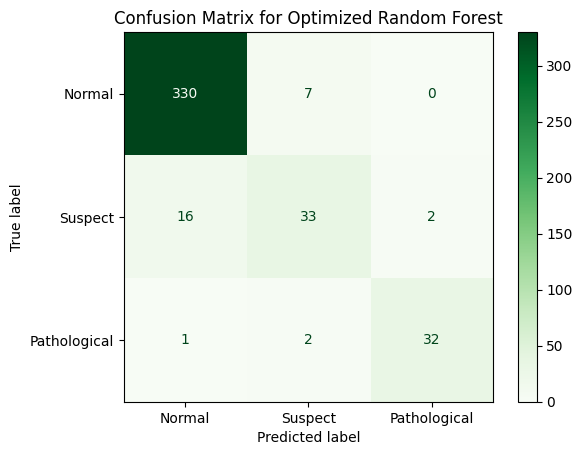

In [88]:
# Random Forest - Confusion Matrix for the Optimized Model
rf_cm = confusion_matrix(y_test, rf_best_predictions, labels=best_rf_model.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Normal", "Suspect", "Pathological"])
plt.figure(figsize=(2, 2))
rf_disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for Optimized Random Forest")
plt.show()


<Figure size 600x400 with 0 Axes>

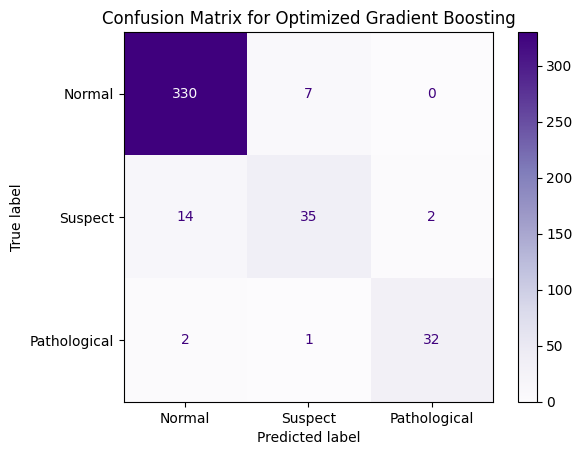

In [60]:
# Gradient Boosting - Confusion Matrix for the Optimized Model
gb_cm = confusion_matrix(y_test, gb_best_predictions, labels=best_gb_model.classes_)
gb_disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm, display_labels=["Normal", "Suspect", "Pathological"])
plt.figure(figsize=(6, 4))
gb_disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix for Optimized Gradient Boosting")
plt.show()

No samples for class Normal in y_test. Skipping PR curve for this class.


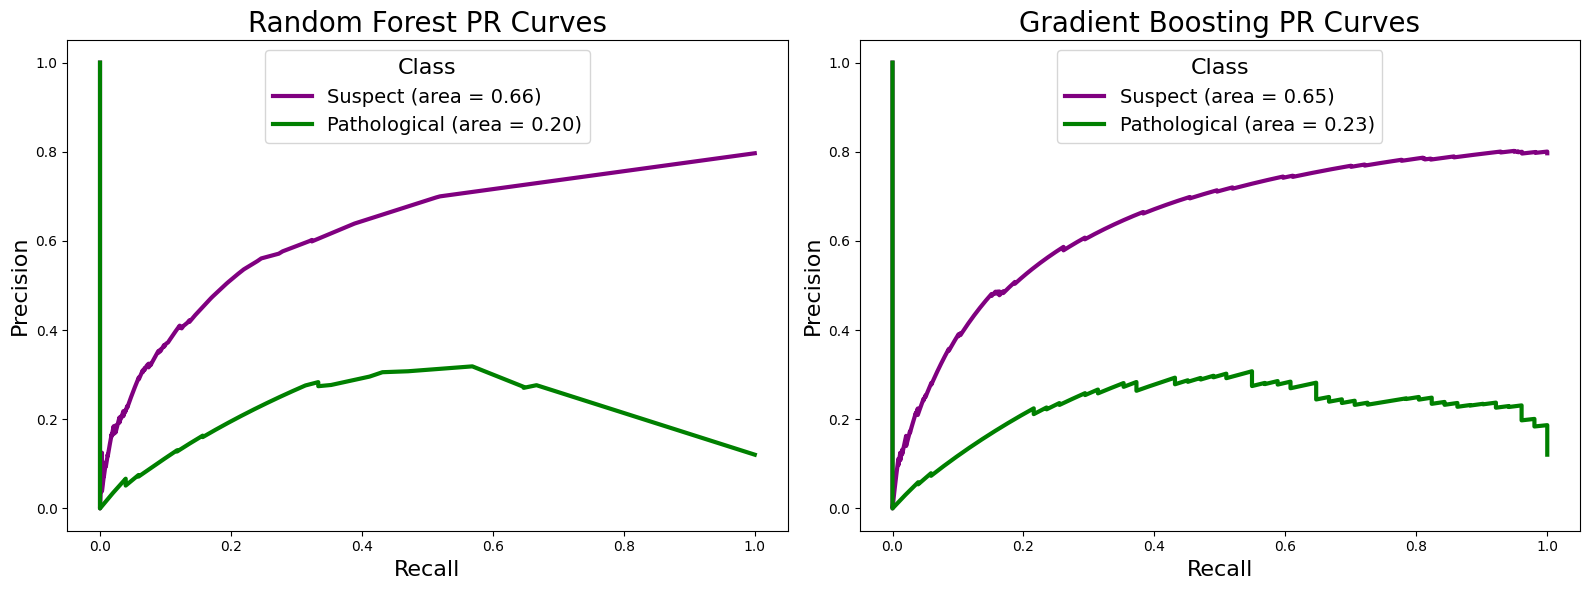

In [128]:
# Compute probabilities for each class
rf_probabilities = best_rf_model.predict_proba(scaled_X_test)
gb_probabilities = best_gb_model.predict_proba(scaled_X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create two side-by-side subplots

class_labels = ["Normal", "Suspect", "Pathological"]
colors = ['blue', 'purple', 'green']  # Colors: blue for Normal, green for Suspect, red for Pathological

for i, class_label in enumerate(class_labels):
    if np.sum(y_test == i) == 0:
        print(f"No samples for class {class_label} in y_test. Skipping PR curve for this class.")
        continue
    
    # Precision-Recall curve for Random Forest
    rf_precision, rf_recall, _ = precision_recall_curve(y_test == i, rf_probabilities[:, i])
    rf_avg_precision = average_precision_score(y_test == i, rf_probabilities[:, i])
    
    # Precision-Recall curve for Gradient Boosting
    gb_precision, gb_recall, _ = precision_recall_curve(y_test == i, gb_probabilities[:, i])
    gb_avg_precision = average_precision_score(y_test == i, gb_probabilities[:, i])
    
    # Plot for Random Forest
    axes[0].plot(rf_recall, rf_precision, label=f'{class_label} (area = {rf_avg_precision:.2f})', color=colors[i], linewidth=3)
    axes[0].set_xlabel('Recall', fontsize=16)
    axes[0].set_ylabel('Precision', fontsize=16)
    axes[0].set_title('Random Forest PR Curves', fontsize=20)
    axes[0].legend(title="Class", title_fontsize='16', fontsize='14', loc='upper center')
    
    # Plot for Gradient Boosting
    axes[1].plot(gb_recall, gb_precision, label=f'{class_label} (area = {gb_avg_precision:.2f})', color=colors[i], linewidth=3)
    axes[1].set_xlabel('Recall', fontsize=16)
    axes[1].set_ylabel('Precision', fontsize=16)
    axes[1].set_title('Gradient Boosting PR Curves', fontsize=20)
    axes[1].legend(title="Class", title_fontsize='16', fontsize='14', loc='upper center')

plt.tight_layout()
plt.show()
